In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, mean_squared_error
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import numpy as np


# Generate Datasets

In [167]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm
from scipy.stats import chi2_contingency

from ISLP import load_data
from ISLP.models import (ModelSpec as MS ,summarize, poly)

from functools import partial
from sklearn.model_selection import (cross_validate ,KFold ,ShuffleSplit)
from sklearn.base import clone
from ISLP.models import sklearn_sm
from sklearn.model_selection import train_test_split

In [168]:
Food = pd.read_csv("dataset/Food_Delivery_Times.csv")
print("Number of rows in the original dataset:", len(Food))

null_rows = Food.isnull().any(axis=1).sum()
print("Number of rows with missing values:", null_rows)

Food = Food.dropna()
print("Number of rows after removing missing values:", len(Food))

Food.head()

Number of rows in the original dataset: 1000
Number of rows with missing values: 117
Number of rows after removing missing values: 883


,Order_ID,Distance_km,Weather,Traffic_Level,Time_of_Day,Vehicle_Type,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,522,7.93,Windy,Low,Afternoon,Scooter,12,1.0,43
1,738,16.42,Clear,Medium,Evening,Bike,20,2.0,84
2,741,9.52,Foggy,Low,Night,Scooter,28,1.0,59
3,661,7.44,Rainy,Medium,Afternoon,Scooter,5,1.0,37
4,412,19.03,Clear,Low,Morning,Bike,16,5.0,68


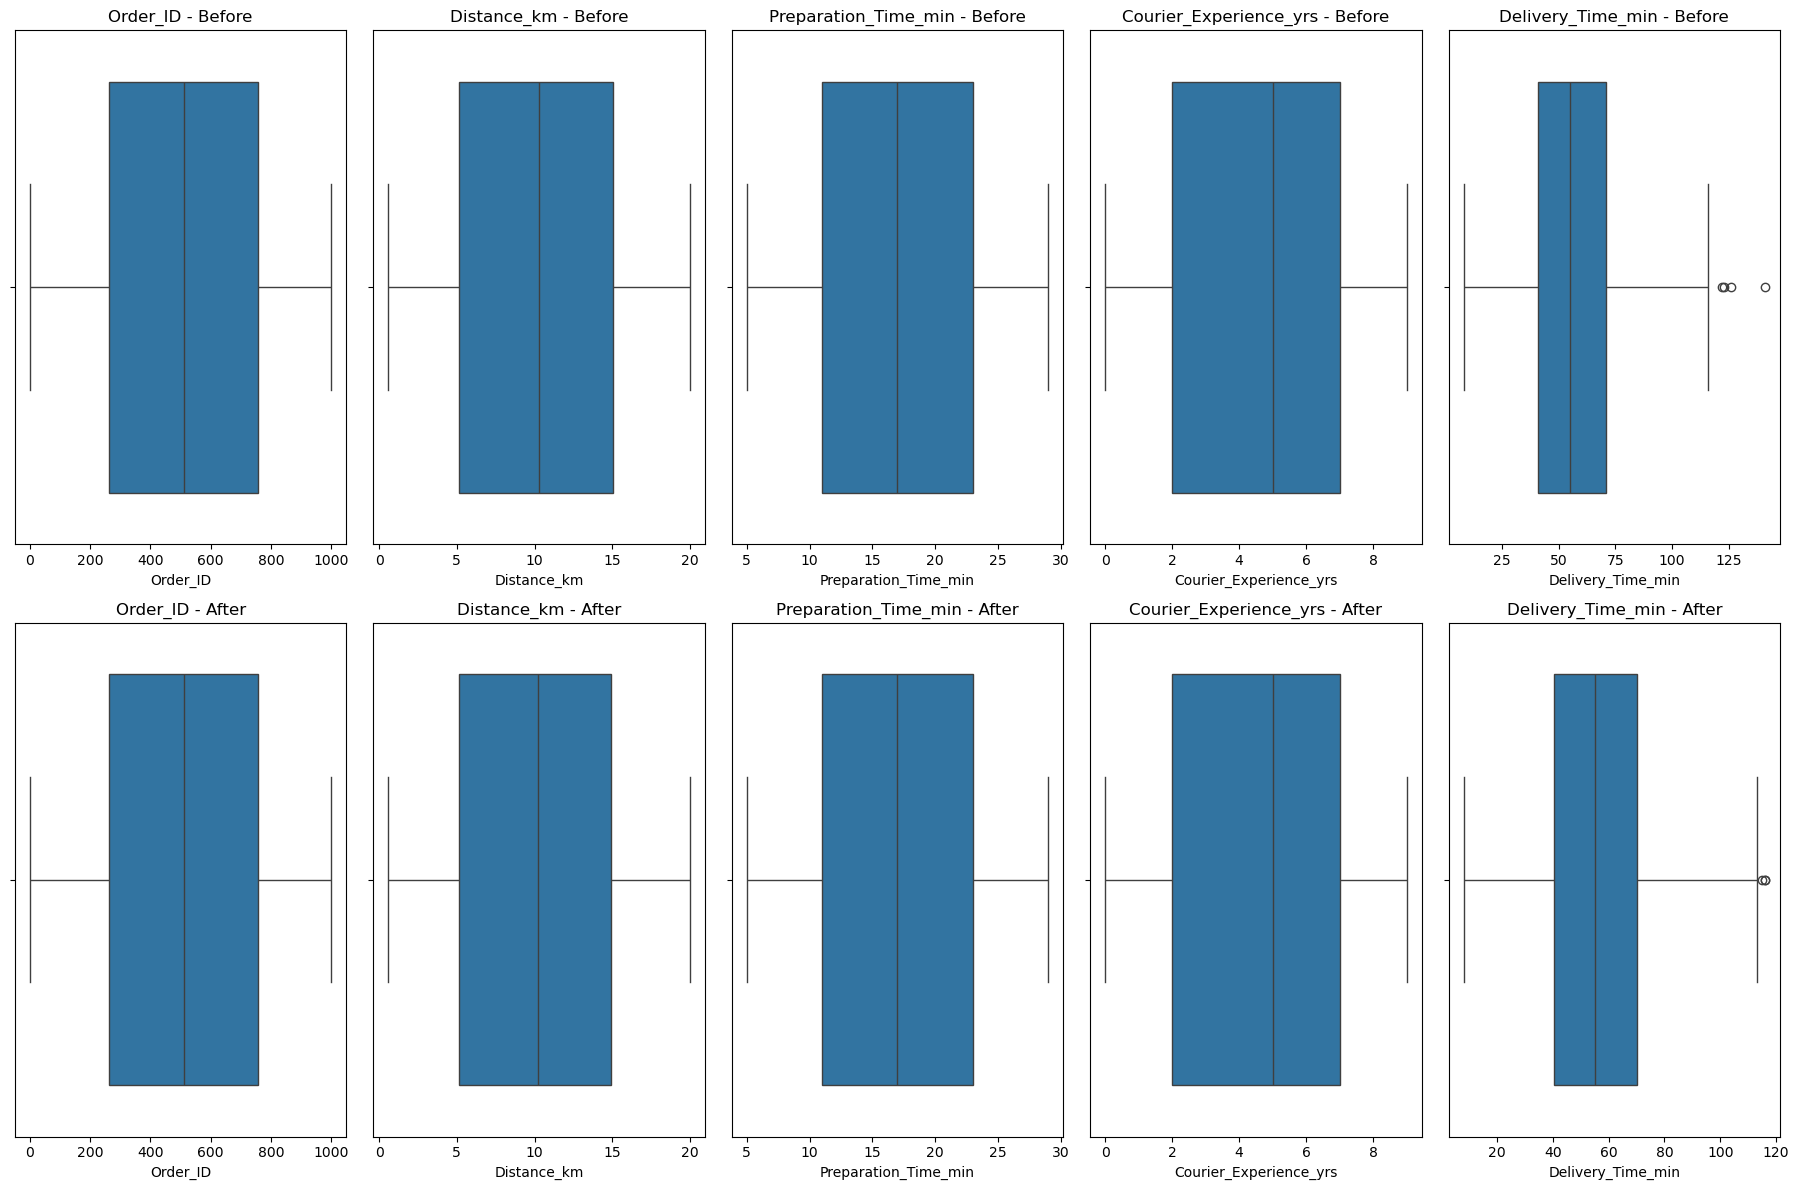

Number of rows after removing outliers 879


In [169]:
numeric_columns = Food.select_dtypes(include=['float64', 'int64']).columns

Food_original = Food.copy()

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

for col in numeric_columns:
    Food = remove_outliers(Food, col)

plt.figure(figsize=(18, 12))
for i, col in enumerate(numeric_columns, 1):

    plt.subplot(2, len(numeric_columns), i)
    sns.boxplot(x=Food_original[col])
    plt.title(f"{col} - Before")

    plt.subplot(2, len(numeric_columns), len(numeric_columns) + i)
    sns.boxplot(x=Food[col])
    plt.title(f"{col} - After")

plt.tight_layout()
plt.show()

print("Number of rows after removing outliers", len(Food))

# DA QUI

# Classification Trees

Classification trees are decision tree models that split the data into regions based on input variables, aiming to predict the output by minimizing variability within each region.  
We return to a non-normalized model, as normalization is not needed because tree-based methods are not sensitive to the scale of the variables.  
As with previous methods, we split the data into train and test sets and use a DecisionTreeRegressor.

In [170]:
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
Food[categorical] = Food[categorical].astype('category')

model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Time_of_Day',
    'Vehicle_Type',
    'Preparation_Time_min',
    'Courier_Experience_yrs'
])

X = model.fit_transform(Food)
y = Food['Delivery_Time_min']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=1
)

In [171]:
tree_model = DecisionTreeRegressor(random_state=2)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=2)

In [172]:
feature_importances = tree_model.feature_importances_
feature_names = tree_model.feature_names_in_

features_with_importances = list(zip(feature_names, feature_importances))

print("Regression Tree:")
print(f"Tree depth: {tree_model.get_depth()}")
print(f"Number of leaves: {tree_model.get_n_leaves()}")
print("Feature importances with names:")
for feature, importance in features_with_importances:
    print(f"{feature}: {importance}")


Regression Tree:
Tree depth: 17
Number of leaves: 398
Feature importances with names:
intercept: 0.0
Distance_km: 0.7001130977997692
Weather[Foggy]: 0.011838111863857362
Weather[Rainy]: 0.002633638595426736
Weather[Snowy]: 0.021215310906338502
Weather[Windy]: 0.009269977625259704
Traffic_Level[Low]: 0.02381615573920294
Traffic_Level[Medium]: 0.003976734885482196
Time_of_Day[Evening]: 0.006089164948819541
Time_of_Day[Morning]: 0.011500492620679566
Time_of_Day[Night]: 0.007010956513370925
Vehicle_Type[Car]: 0.007979015066439596
Vehicle_Type[Scooter]: 0.009406386313477729
Preparation_Time_min: 0.15618442630794976
Courier_Experience_yrs: 0.02896653081392608


The resulting tree is very complex, with 17 levels and 398 leaves, suggesting strong overfitting.  
Regarding variable importance information, the results are consistent with those observed in the previous models.


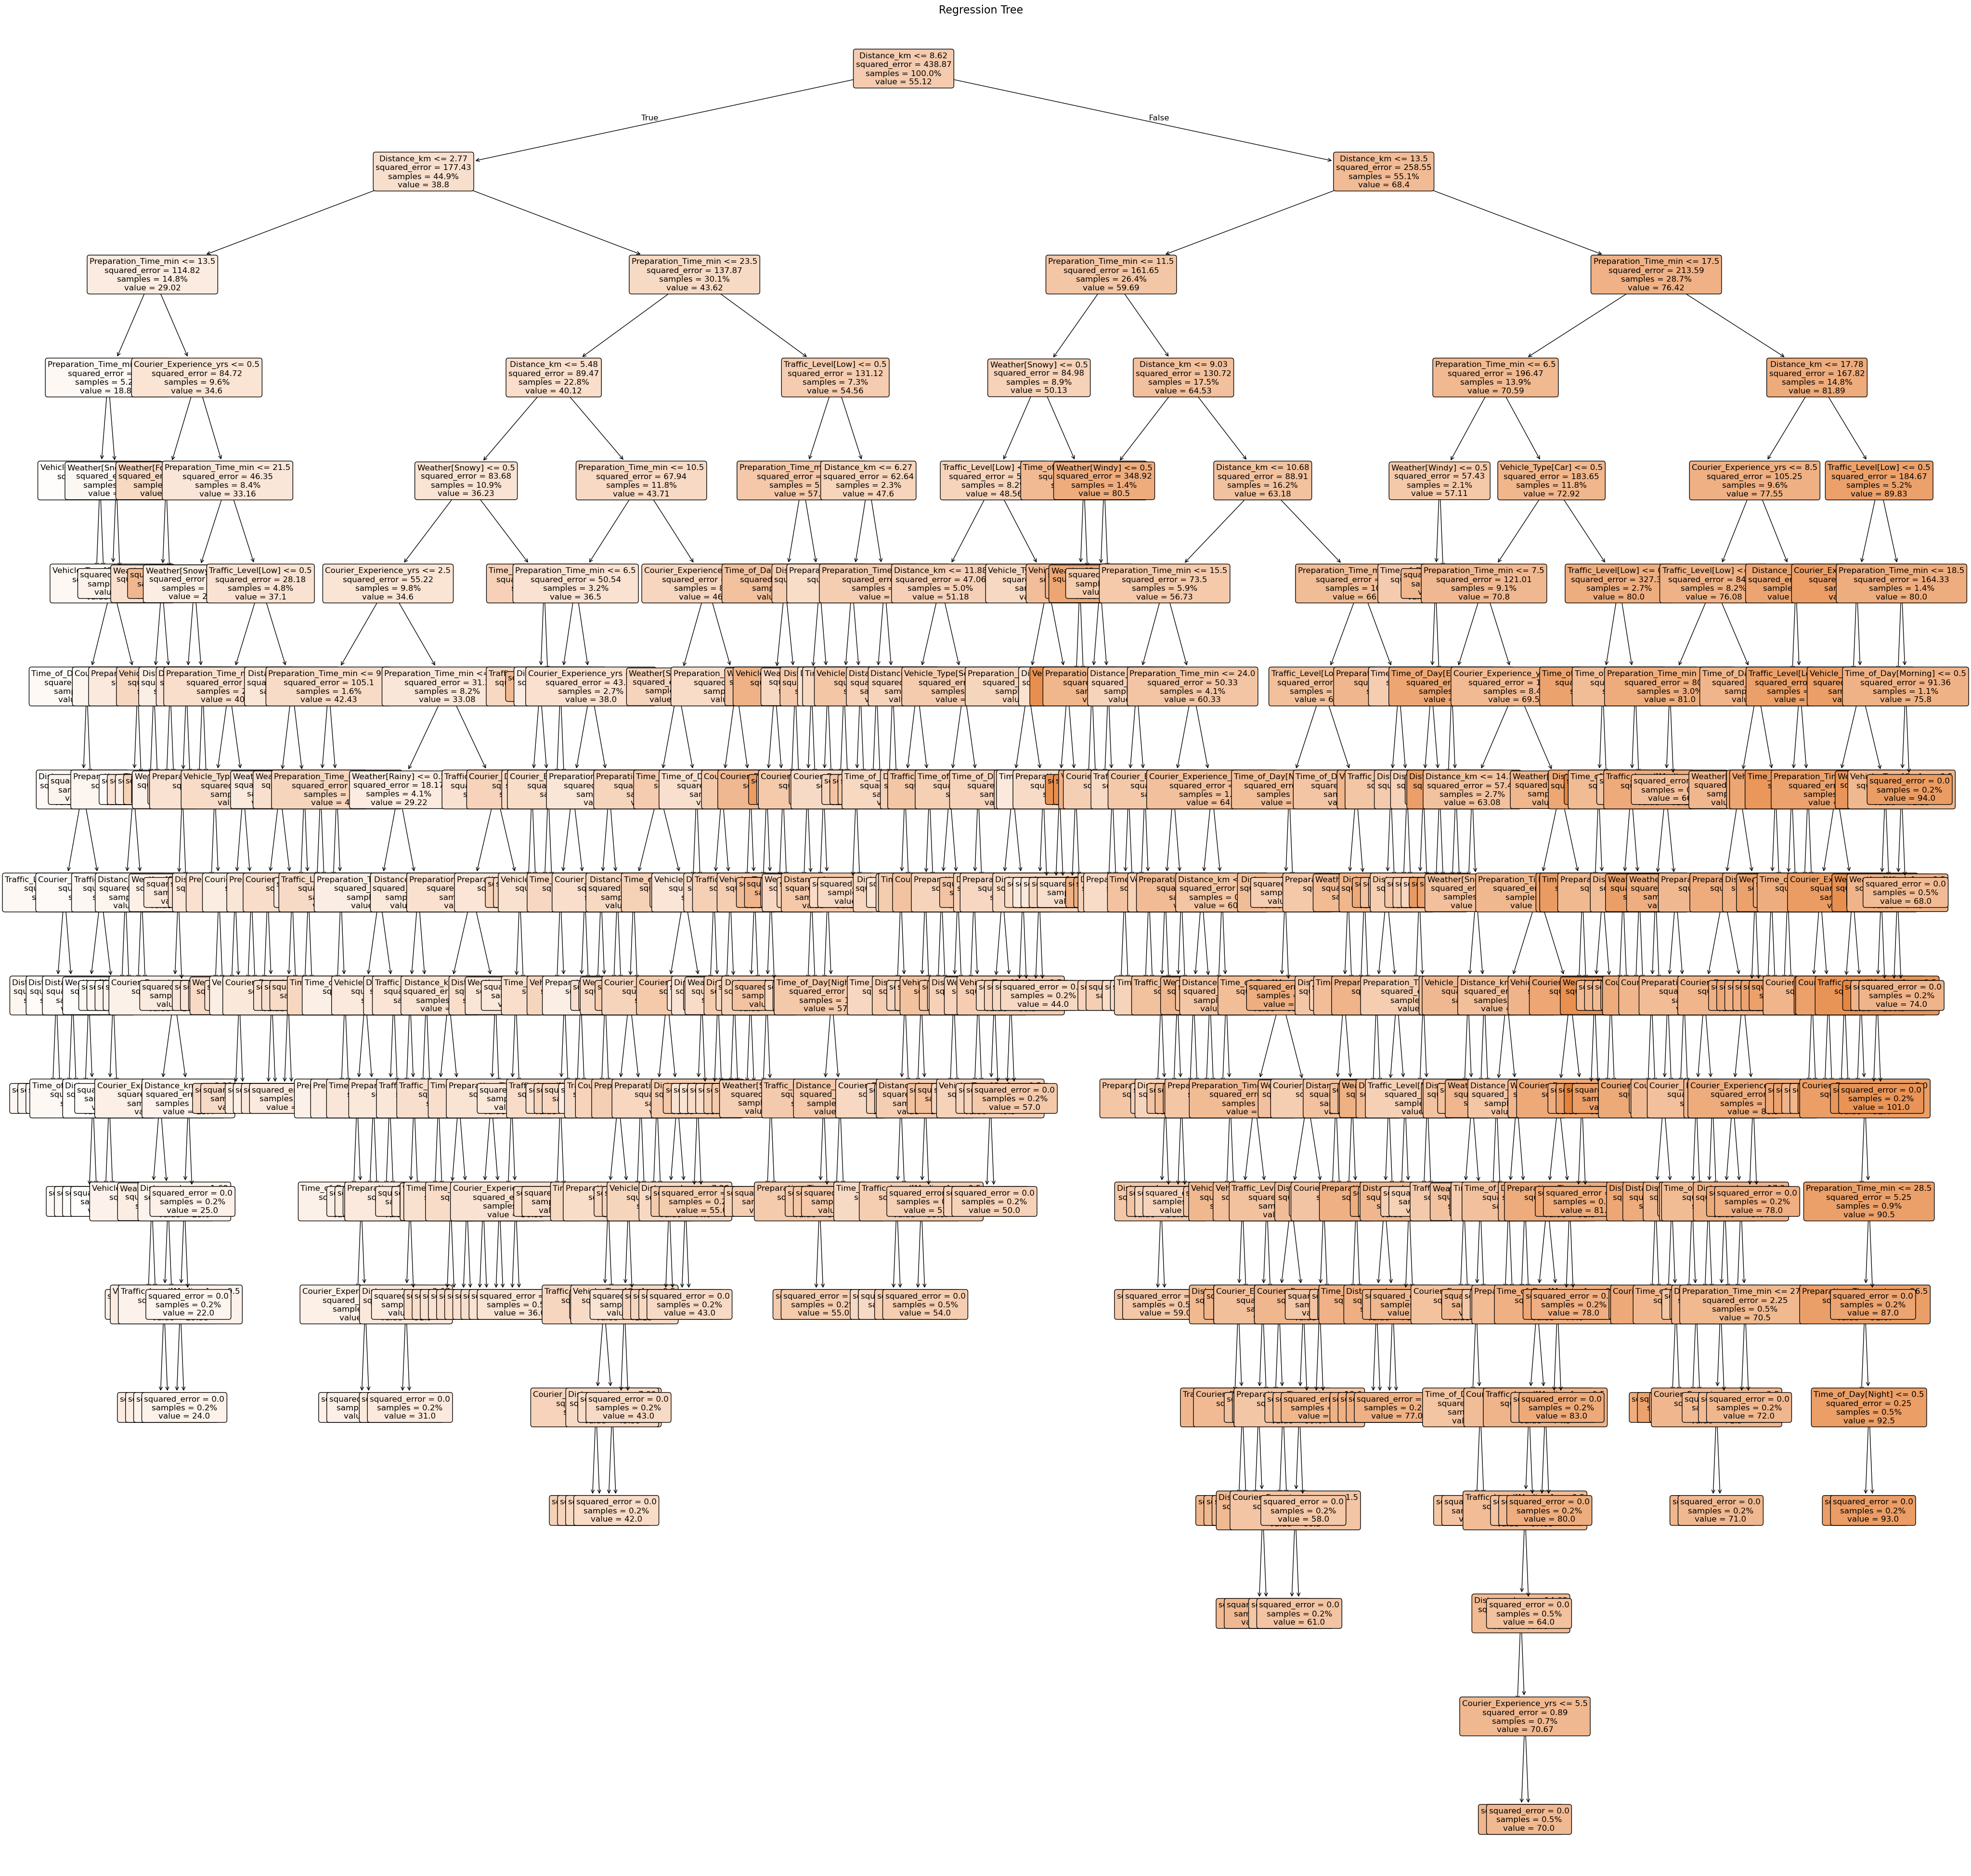

In [173]:
plt.figure(figsize=(50, 50)) 
plot_tree(tree_model, 
          feature_names=X.columns, 
          filled=True, 
          rounded=True, 
          proportion=True,  
          fontsize=12,  
          precision=2)  

plt.title('Regression Tree', fontsize=16) 
plt.show()


The plot confirms the enormous complexity of the tree.


In [174]:
y_pred = tree_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {np.sqrt(mse):.4f}")


MAE: 10.9091
R2: 0.4533
MSE: 243.5227
RMSE: 15.6052


The residual analysis shows worse results compared to the previous models, although worse performance was expected given the enormous size of the tree.  
We proceed to simplify the tree by studying the maximum depth.

In [175]:
max_depth_values = range(1, 100) 
cv_scores = []

for depth in max_depth_values:
    tree_cv = DecisionTreeRegressor(criterion='squared_error', max_depth=depth, random_state=2)
    scores = cross_val_score(tree_cv, X_train, y_train, cv=10, scoring='r2')
    cv_scores.append(np.mean(scores))


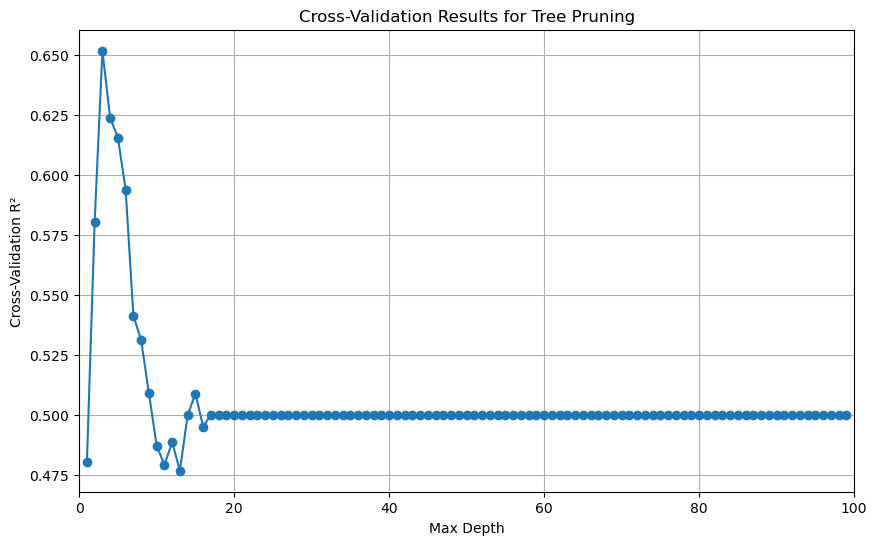

In [176]:
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, cv_scores, 'o-')
plt.xlabel('Max Depth')
plt.ylabel('Cross-Validation R²')
plt.title('Cross-Validation Results for Tree Pruning')
plt.grid(True)
plt.xlim(0, 100)
plt.show()


The graph shows the effect of the decision tree depth on performance, using cross-validation and the R² score.  
The results show an initial increase in R² followed by a decrease, indicating the optimization between underfitting and overfitting.  
The optimal depth seems to be 3, as this is where R² is maximum.


In [177]:
best_depth = max_depth_values[np.argmax(cv_scores)]
print(f"Best depth from cross-validation: {best_depth}")


Best depth from cross-validation: 3


The optimal depth of 3 is confirmed, so we proceed with pruning.


In [178]:
pruned_tree = DecisionTreeRegressor(max_depth=best_depth, random_state=2)
pruned_tree.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=3, random_state=2)

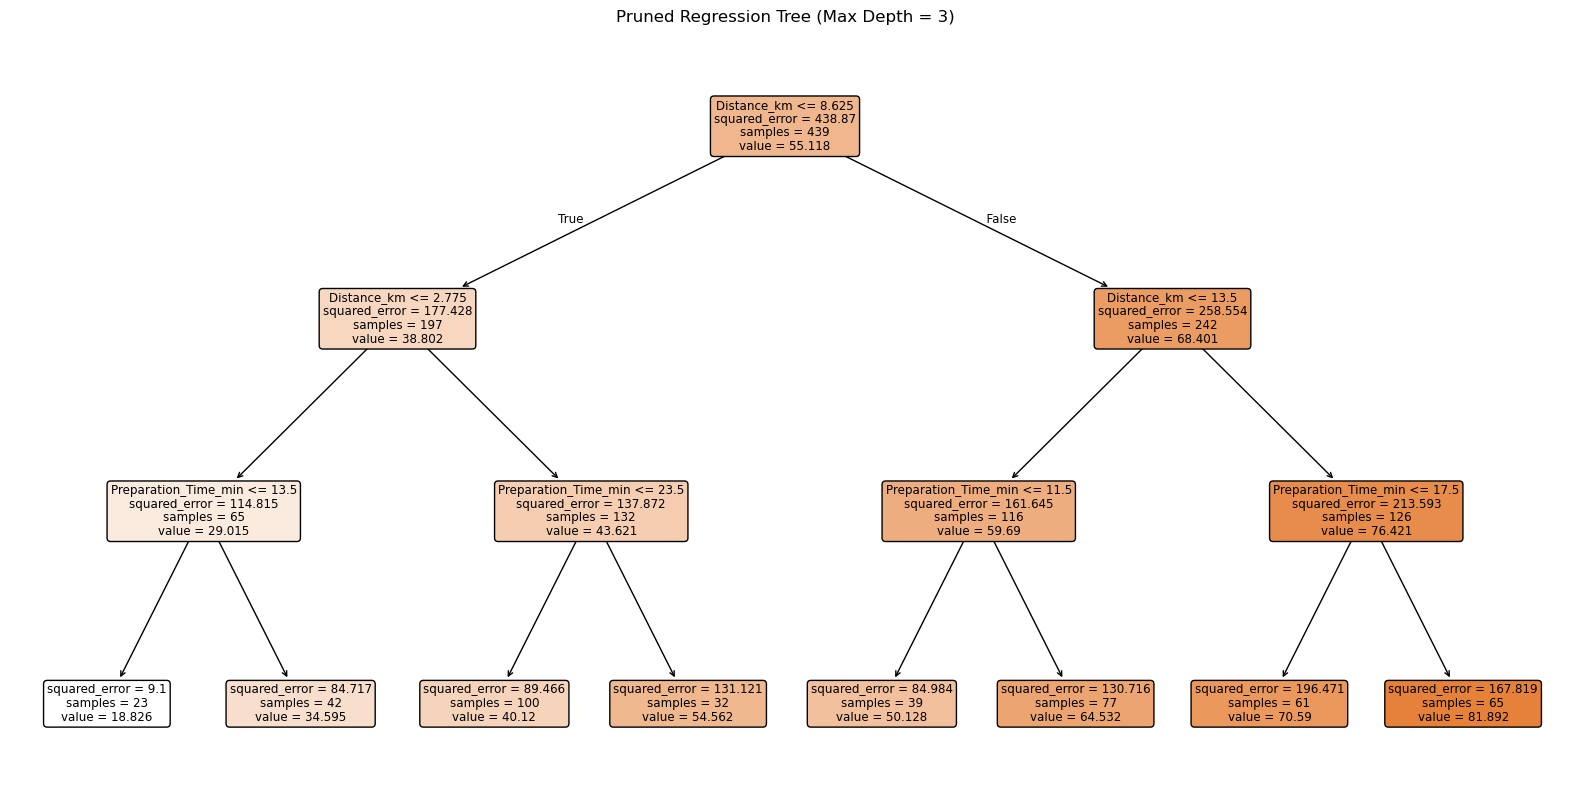

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(pruned_tree, feature_names=X.columns, filled=True, rounded=True)
plt.title(f'Pruned Regression Tree (Max Depth = {best_depth})')
plt.show()


The pruned tree is much simpler and easier to explain.  
The only variables considered in the end are _Distance_km_ and _Preparation_Time_min_.  
Dark orange indicate more extreme predicted values (higher or lower), while lighter or white colors indicate values close to the target mean.  
These do not represent categories, but rather continuous value gradations.


In [180]:
y_pred_pruned = pruned_tree.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_pruned)
mse = mean_squared_error(y_test, y_pred_pruned)
r2 = r2_score(y_test, y_pred_pruned)

print(f"MAE: {mae:.4f}")
print(f"R2: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {np.sqrt(mse):.4f}")


MAE: 9.4381
R2: 0.6079
MSE: 174.6271
RMSE: 13.2147


With pruning, the results have also improved.


- ## Bagging

In [181]:
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
Food[categorical] = Food[categorical].astype('category')

# Crea il modello con le specifiche
model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Time_of_Day',
    'Vehicle_Type',
    'Preparation_Time_min',
    'Courier_Experience_yrs'
])

# Applica la trasformazione
X = model.fit_transform(Food)
y = Food['Delivery_Time_min']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=1
)

In [182]:
# Bagging (Random Forest with max features = total features)
bagg_model = RandomForestRegressor(
    n_estimators=500, 
    max_features=X.shape[1],  # Use all features (equivalent to bagging)
    random_state=1,
    bootstrap=True  # Use bootstrap samples
)
bagg_model.fit(X_train, y_train)

RandomForestRegressor(max_features=15, n_estimators=500, random_state=1)

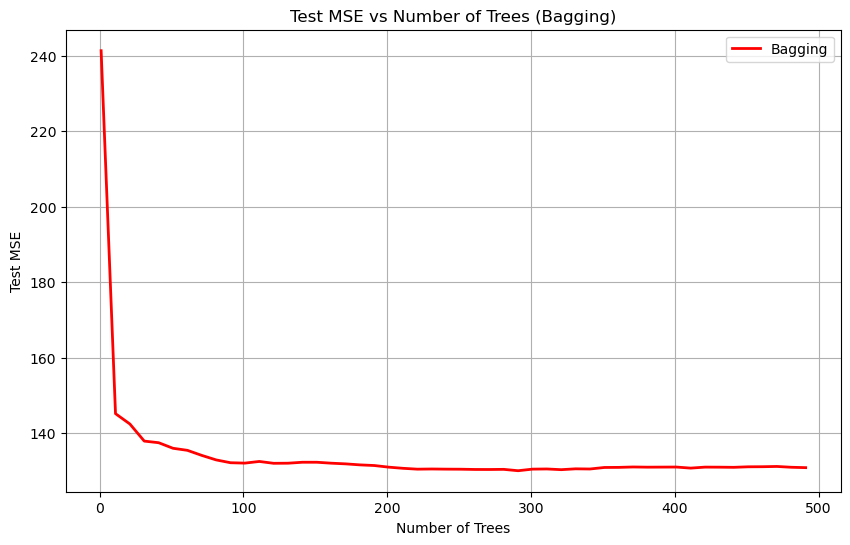

In [183]:
# Plot error vs number of trees
error_rate = []
X_test_array = X_test.to_numpy()

for i in range(1, 501, 10):
    y_pred_bagg = np.mean([t.predict(X_test_array) for t in bagg_model.estimators_[:i]], axis=0)
    error_rate.append(mean_squared_error(y_test, y_pred_bagg))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 501, 10), error_rate, 'r-', lw=2, label='Bagging')
plt.xlabel('Number of Trees')
plt.ylabel('Test MSE')
plt.title('Test MSE vs Number of Trees (Bagging)')
plt.legend()
plt.grid(True)
plt.show()


In [184]:
# Predictions and evaluation
y_pred_bagg = bagg_model.predict(X_test)
mse_bagg = mean_squared_error(y_test, y_pred_bagg)
print(f"Bagging MSE: {mse_bagg:.4f}")
print(f"Bagging RMSE: {np.sqrt(mse_bagg):.4f}")

Bagging MSE: 130.8945
Bagging RMSE: 11.4409


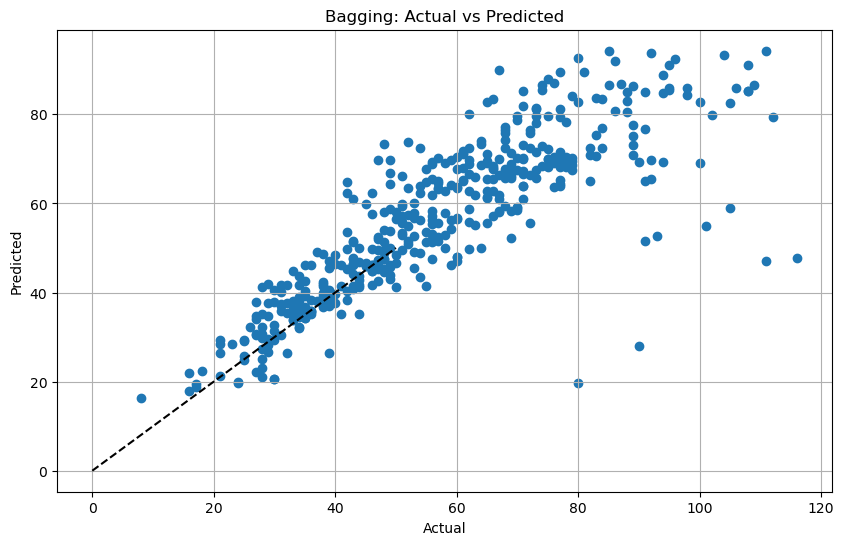

In [185]:
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_bagg)
plt.plot([0, 50], [0, 50], 'k--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Bagging: Actual vs Predicted')
plt.grid(True)
plt.show()
# Se sono sulla bisettrice il modello funziona bene, modello con bagging stimato corretto. Migliore del singolo albero ma comunque peggiore dei lineari

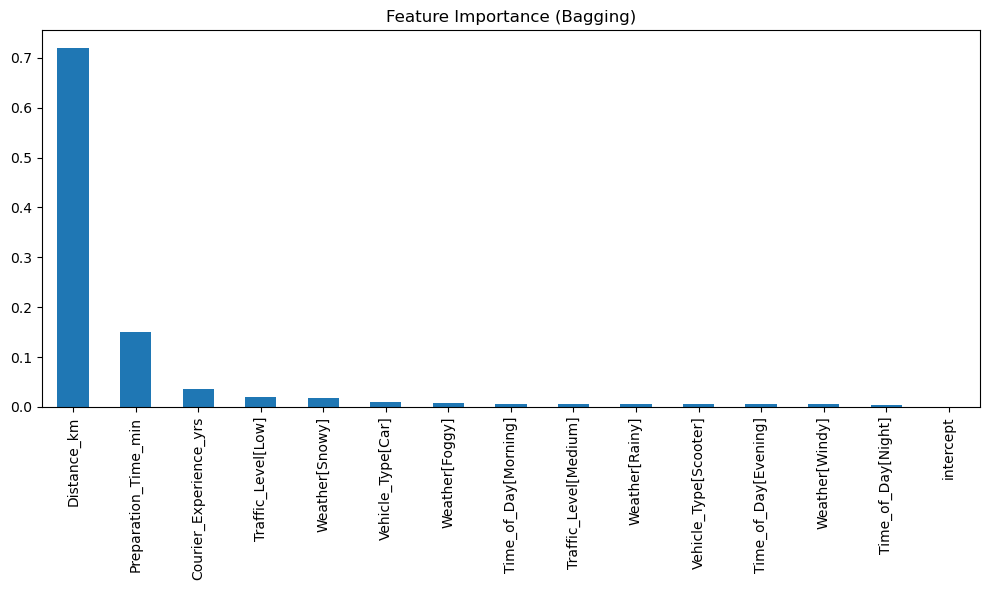

In [186]:
# Feature importance for bagging
importance_bagg = pd.Series(bagg_model.feature_importances_, index=X.columns)
importance_bagg.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
importance_bagg.plot(kind='bar')
plt.title('Feature Importance (Bagging)')
plt.tight_layout()
plt.show()

# Random forest

In [187]:
# Random Forest (uses sqrt of number of features by default)
forest_model = RandomForestRegressor(
    n_estimators=100, 
    max_features='sqrt',  # Default for RandomForest
    random_state=1
)
forest_model.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', random_state=1)

In [188]:
# Error vs number of trees for Random Forest
error_rate_rf = []
X_test_array = X_test.to_numpy()  # Se non l'hai già fatto sopra

for i in range(1, 101, 2):
    y_pred_rf = np.mean([t.predict(X_test_array) for t in forest_model.estimators_[:i]], axis=0)
    error_rate_rf.append(mean_squared_error(y_test, y_pred_rf))


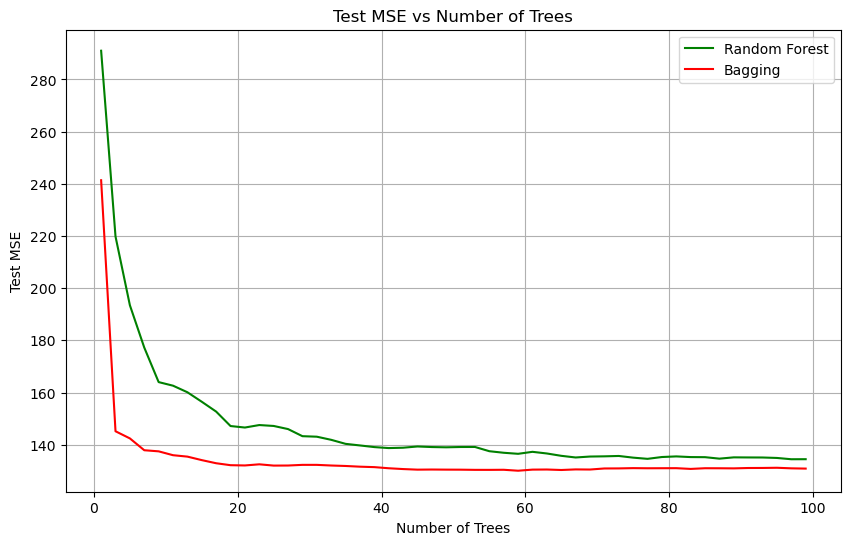

In [189]:
# Plot both bagging and random forest error rates
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101, 2), error_rate_rf[:50], 'g-', label='Random Forest')
plt.plot(range(1, 101, 2), error_rate[:50], 'r-', label='Bagging')
plt.xlabel('Number of Trees')
plt.ylabel('Test MSE')
plt.title('Test MSE vs Number of Trees')
plt.legend()
plt.grid(True)
plt.show()
# In questo caso bagging funziona meglio, quindi questo è peggio

Random Forest MSE: 134.2502
Random Forest RMSE: 11.5866


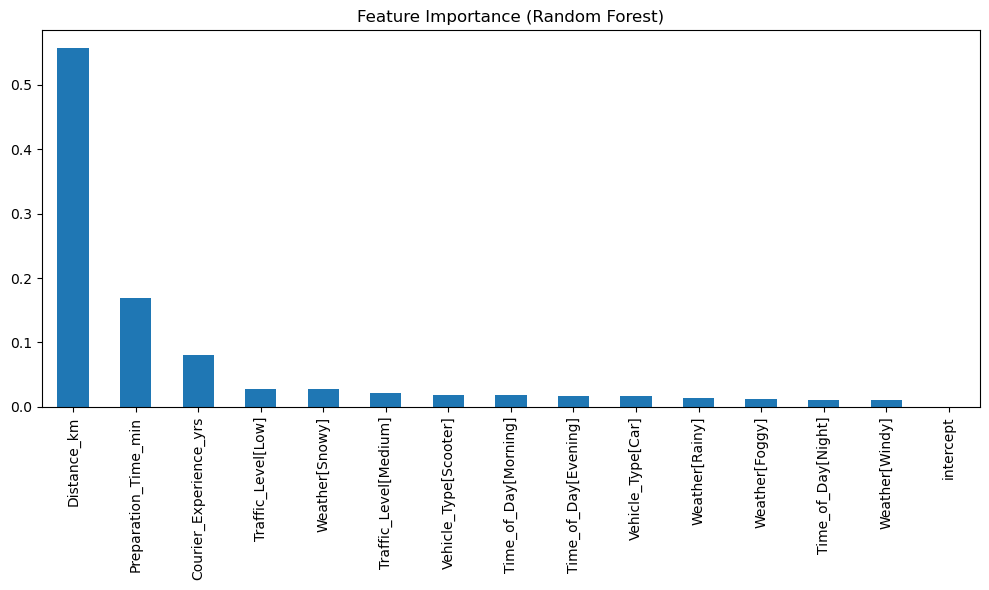

In [190]:
# Evaluation of Random Forest
y_pred_rf = forest_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Random Forest MSE: {mse_rf:.4f}")
print(f"Random Forest RMSE: {np.sqrt(mse_rf):.4f}")

# Feature importance for Random Forest
importance_rf = pd.Series(forest_model.feature_importances_, index=X.columns)
importance_rf.sort_values(ascending=False, inplace=True)
plt.figure(figsize=(10, 6))
importance_rf.plot(kind='bar')
plt.title('Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()
# Con random forest forziamo le altre variabili ad avere un ruolo più rilevante

# -------------------- Boosting --------------------

In [191]:
categorical = ['Weather', 'Traffic_Level', 'Time_of_Day', 'Vehicle_Type']
Food[categorical] = Food[categorical].astype('category')

# Crea il modello con le specifiche
model = MS([
    'Distance_km',
    'Weather',
    'Traffic_Level',
    'Time_of_Day',
    'Vehicle_Type',
    'Preparation_Time_min',
    'Courier_Experience_yrs'
])

# Applica la trasformazione
X = model.fit_transform(Food)
y = Food['Delivery_Time_min']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=1
)

In [192]:
# Gradient Boosting
boost_model = GradientBoostingRegressor(
    n_estimators=5000,
    max_depth=4,
    learning_rate=0.001,
    loss='squared_error',  # equivalent to 'gaussian' in R's gbm
    random_state=1
)
boost_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, max_depth=4, n_estimators=5000,
                          random_state=1)

In [193]:
# Predictions and evaluation
y_pred_boost = boost_model.predict(X_test)
mse_boost = mean_squared_error(y_test, y_pred_boost)
print(f"Boosting MSE: {mse_boost:.4f}")
print(f"Boosting RMSE: {np.sqrt(mse_boost):.4f}")

# Compare all methods
methods = ['Bagging', 'Random Forest', 'Boosting']
mse_values = [mse_bagg, mse_rf, mse_boost]

Boosting MSE: 120.1525
Boosting RMSE: 10.9614


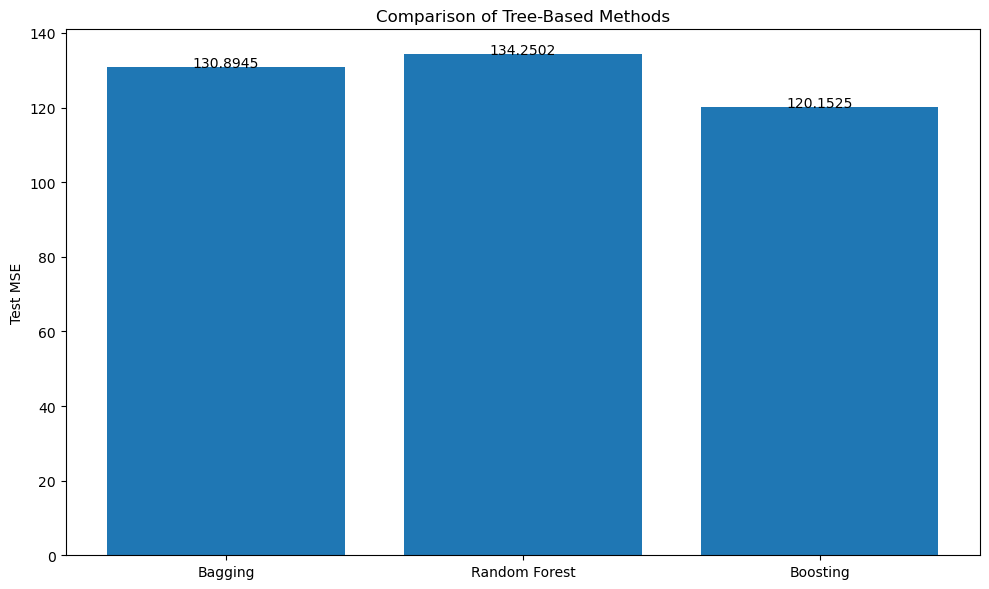

In [194]:
plt.figure(figsize=(10, 6))
plt.bar(methods, mse_values)
plt.ylabel('Test MSE')
plt.title('Comparison of Tree-Based Methods')
for i, v in enumerate(mse_values):
    plt.text(i, v + 0.1, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()